In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords,words

import warnings 
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_colwidth", 200)
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.titlesize'] = 20

In [4]:
train  = pd.read_csv('train_E6oV3lV.csv')
test = pd.read_csv('test_tweets_anuFYb8.csv')

In [5]:
print(train.shape,test.shape)
train.head()

(31962, 3) (17197, 2)


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [6]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [7]:
combi = pd.concat([train,test],axis=0).reset_index(drop=True)
combi.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation


In [8]:
# Removing punctuation & Stopwords

stop_words = stopwords.words('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'ve", " ", text)
    text = re.sub(r"i'm", " ", text)
    text = re.sub(r"\'re", " ", text)
    text = re.sub(r"\'d", " ", text)
    text = re.sub(r"\'ll", " ", text)
    text = re.sub('\n',' ',text) 
    text = re.sub('[^a-zA-Z#]', ' ', text)       #Removing punctuations but keeping hashtags
    text = re.sub('\s+', ' ', text)      
    text = ' '.join([i for i in text.split() if i not in stop_words])
    return text

In [9]:
combi['tweet'] = combi.tweet.apply(lambda x: clean_text(x))
combi.head()

,id,label,tweet
0,1,0.0,user father dysfunctional selfish drags kids dysfunction #run
1,2,0.0,user user thanks #lyft credit cannot use cause offer wheelchair vans pdx #disapointed #getthanked
2,3,0.0,bihday majesty
3,4,0.0,#model love u take u time ur
4,5,0.0,factsguide society #motivation


In [10]:
combi.tweet[3]

'#model love u take u time ur'

In [11]:
#TOKENIZATION and removing words less than 3 in length

from nltk.tokenize import word_tokenize
combi['tweet'] = combi.tweet.apply(lambda x: word_tokenize(x.lower())) #word tokenization
combi['tweet'] = combi.tweet.apply(lambda x: [i for i in x if len(i)>3])
combi.head()

,id,label,tweet
0,1,0.0,"[user, father, dysfunctional, selfish, drags, kids, dysfunction]"
1,2,0.0,"[user, user, thanks, lyft, credit, cause, offer, wheelchair, vans, disapointed, getthanked]"
2,3,0.0,"[bihday, majesty]"
3,4,0.0,"[model, love, take, time]"
4,5,0.0,"[factsguide, society, motivation]"


In [12]:
#LEMMATIZATION

from nltk.stem import WordNetLemmatizer

def split_into_lemmas(text):
    lemma = []
    lemmatizer = WordNetLemmatizer()
    for word in text:
        a = lemmatizer.lemmatize(word)
        lemma.append(a)
    return ' '.join(lemma)

combi['tweet'] = combi.tweet.apply(split_into_lemmas)
combi.head()

,id,label,tweet
0,1,0.0,user father dysfunctional selfish drag kid dysfunction
1,2,0.0,user user thanks lyft credit cause offer wheelchair van disapointed getthanked
2,3,0.0,bihday majesty
3,4,0.0,model love take time
4,5,0.0,factsguide society motivation


# Word Embedding using FastText

Using **FastText** trained by Facebook for Word Embedding 

* *P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, [Enriching Word Vectors with Subword Information]( https://arxiv.org/abs/1607.04606)*

In [15]:
from datetime import datetime
print(datetime.now().strftime('%H:%M:%S'))

embed_dim = 300
embed_ind= {}
f = open('F:\\Video Courses\\DATA SCIENCE\\Python packages\\FastText\\wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embed_dim)
    word   = values[0]
    coefs  = np.asarray(values[1:], dtype='float32')
    embed_ind[word] = coefs
f.close()

print(datetime.now().strftime('%H:%M:%S'))
len(embed_ind)

18:30:18
18:38:06


2519371

In [16]:
def get_vec(token, dim,embed_ind):
    '''
    This function finds vector of each token present in a sentence and then averages to get the vector of whole sentence.
    '''
    vec=0       
    cnt = 0
        
    for word in token:
        try:
            vec_word = embed_ind.get(word)
            if vec_word is not None:
                vec += embed_ind.get(word)
                cnt += 1
        except KeyError:         
            continue
            
    if cnt != 0:
        vec /= cnt
    return vec

In [17]:
token_tweet = combi.tweet.apply(lambda x: x.split()) 

dim=300
fasttext_mat = np.zeros((len(token_tweet), dim))
for i,token in enumerate(token_tweet):
    fasttext_vec = get_vec(token,dim,embed_ind)
    fasttext_mat[i] = fasttext_vec

fasttext_df = pd.DataFrame(fasttext_mat)
print(fasttext_df.shape)

(49159, 300)


In [18]:
train_fasttext = fasttext_df[:31962]
test_fasttext = fasttext_df[31962:]

In [19]:
X = train_fasttext
y = train.label

# Model Building

Now we will build the model for predicting the sentiment of tweet using different algorithms mentioned below:

1. Logistic Regression
2. Naive Bayes 
3. K Nearest Neighbor
4. Support Vector Machine
5. Decision Tree
6. Random Forest
7. XGBoost
8. LightGBM

# 1. Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1029)

In [22]:
model = LogisticRegression()
model.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 then 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.6257928118393233


[[2872   71]
 [ 106  148]]


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2943
           1       0.68      0.58      0.63       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.82      0.78      0.80      3197
weighted avg       0.94      0.94      0.94      3197



predicting test dataset tweets and creating submission file

In [24]:
test_pred = model.predict_proba(test_fasttext)
test_pred = test_pred[:,1] >= 0.3
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_LR.csv', index=False)

###### Public Leaderboard score:   0.5568513119533528

# 2. Naive Bayes

In [25]:
from sklearn import naive_bayes

In [26]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

ValueError: Input X must be non-negative

###### As the component of vectors for any tweet contain positive as well as negative values and hence Naive Bayes can't be used to create model.

# 3. K Nearest Neighbor

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
cv_scores=[]
for i in range(1,10):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test,y_pred)
    cv_scores.append(score)

Text(0.5, 1.0, 'K vs F1 score')

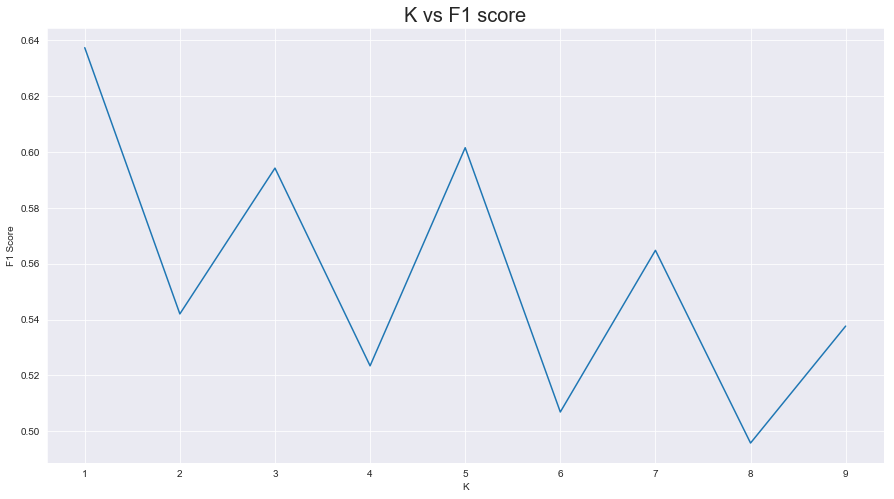

In [29]:
plt.plot(range(1,10),cv_scores)
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.title('K vs F1 score')

From the above plot, it is clearly visible that our model's score is max at K=1. Choosing K = 1 for building the model.

In [30]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.6373165618448637


[[2872   71]
 [ 102  152]]


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2943
           1       0.68      0.60      0.64       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.82      0.79      0.80      3197
weighted avg       0.94      0.95      0.94      3197



predicting test dataset tweets and creating submission file

In [31]:
test_pred = model.predict(test_fasttext)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_KNN.csv', index=False)

###### Public Leaderboard score :  0.6109510086455331

# 4. Support Vector Machine

In [32]:
from sklearn import svm

In [33]:
model = svm.SVC(kernel='linear', C=10, probability=True)
model.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [34]:
y_pred = model.predict_proba(X_test) 
y_pred = y_pred[:,1] >= 0.3        # if prediction is greater than or equal to 0.3 then 1 else 0
y_pred = y_pred.astype(np.int)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.6136865342163357


[[2883   60]
 [ 115  139]]


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2943
           1       0.70      0.55      0.61       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.83      0.76      0.79      3197
weighted avg       0.94      0.95      0.94      3197



In [35]:
test_pred = model.predict_proba(test_fasttext)
test_pred = test_pred[:,1] >= 0.3   
test_pred = test_pred.astype(np.int)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_SVM.csv', index=False)

###### Public Leaderboard score :  0.5362776025236594

# 5. Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
model = DecisionTreeClassifier(criterion='entropy',min_samples_split =10,max_features=300)
model.fit(X_train,y_train)  

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.43137254901960786


[[2797  146]
 [ 144  110]]


              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2943
           1       0.43      0.43      0.43       254

   micro avg       0.91      0.91      0.91      3197
   macro avg       0.69      0.69      0.69      3197
weighted avg       0.91      0.91      0.91      3197



In [39]:
test_pred = model.predict(test_fasttext)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_DTree.csv', index=False)

###### Public Leaderboard score :  0.45746164574616455

# 6. Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
model = RandomForestClassifier(n_estimators=40,criterion='entropy',min_samples_split =5,max_features=300)
model.fit(X_train,y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=300, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.49577464788732395


[[2930   13]
 [ 166   88]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2943
           1       0.87      0.35      0.50       254

   micro avg       0.94      0.94      0.94      3197
   macro avg       0.91      0.67      0.73      3197
weighted avg       0.94      0.94      0.93      3197



In [43]:
test_pred = model.predict(test_fasttext)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_RF.csv', index=False)

###### Public Leaderboard score :  0.5019157088122606

# 7. XGBoost

In [44]:
import xgboost as xgb

In [45]:
model = xgb.XGBClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.8,colsample_bytree=0.7)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bytree=0.7, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=30,
       min_child_weight=5, n_estimators=200, nthread=-1,
       objective='binary:logistic', seed=0, silent=True, subsample=0.8)

In [46]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.5906735751295337


[[2925   18]
 [ 140  114]]


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2943
           1       0.86      0.45      0.59       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.91      0.72      0.78      3197
weighted avg       0.95      0.95      0.94      3197



In [47]:
test_pred = model.predict(test_fasttext)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_XGB.csv', index=False)

###### Public Leaderboard score :   0.5573770491803278

# 8. LightGBM

In [48]:
import lightgbm as lgb

In [49]:
model = lgb.LGBMClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.8,colsample_bytree=0.7)
model.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        importance_type='split', learning_rate=0.1, max_depth=30,
        min_child_samples=20, min_child_weight=5, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [50]:
y_pred = model.predict(X_test)

print(f1_score(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

0.6268656716417911


[[2921   22]
 [ 128  126]]


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2943
           1       0.85      0.50      0.63       254

   micro avg       0.95      0.95      0.95      3197
   macro avg       0.90      0.74      0.80      3197
weighted avg       0.95      0.95      0.95      3197



In [51]:
test_pred = model.predict(test_fasttext)

submission = pd.read_csv('sample_submission_gfvA5FD.csv')
submission['label'] = test_pred
submission.to_csv('sub_fasttext_LGBM.csv', index=False)

###### Public Leaderboard score :  0.5942275042444822

| Algorithm | Model F1 Score | Public F1 Score |
| --------- | ---------- | ------------------- |
| Logistic Regression | 0.6257928118393233 | 0.5568513119533528 |
| K Nearest Neighbor |  0.6373165618448637 | 0.6109510086455331  |
| SVM | 0.6136865342163357 | 0.5362776025236594 |
| Decision Tree | 0.6136865342163357 | 0.45746164574616455 |
| Random Forest | 0.49577464788732395 | 0.5019157088122606 |
| XGBoost | 0.5906735751295337  | 0.5573770491803278 |
| LightGBM | 0.6268656716417911  | 0.5942275042444822 |